
--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB
None

--- First 5 Rows ---
   Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Elec

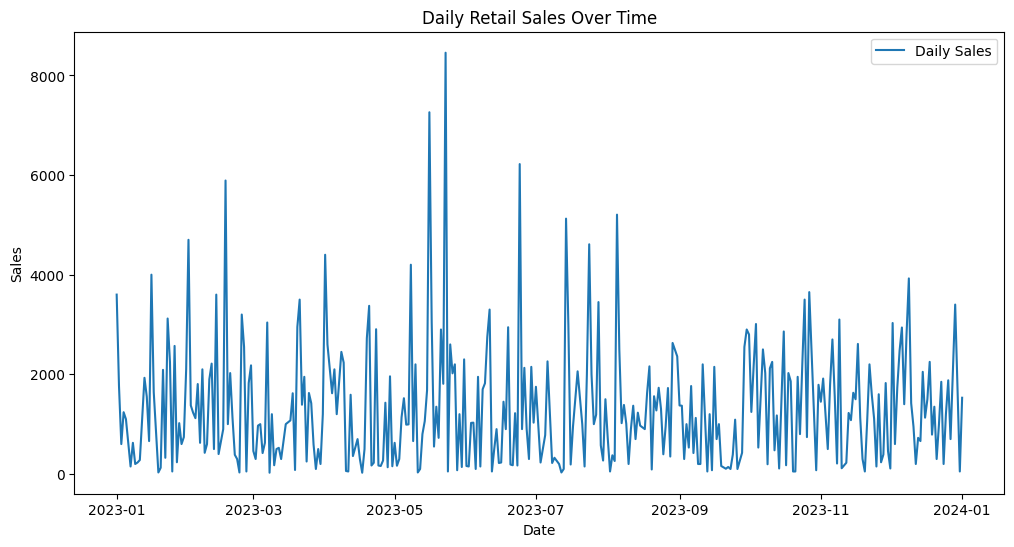

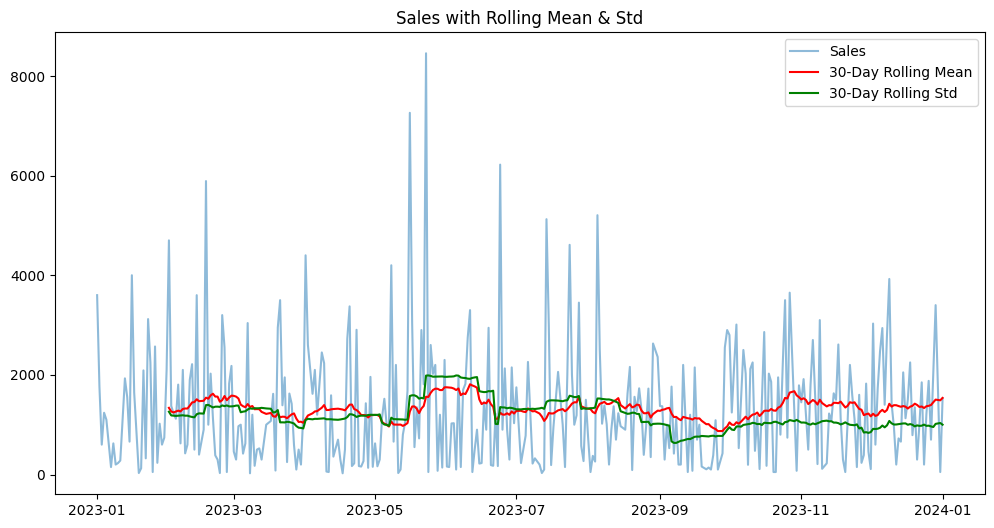


Train size: 276, Test size: 69

--- Model Summary ---
                                     SARIMAX Results                                     
Dep. Variable:                      Total Amount   No. Observations:                  276
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2236.610
Date:                           Sun, 31 Aug 2025   AIC                           4483.220
Time:                                   04:49:49   BIC                           4501.004
Sample:                                        0   HQIC                          4490.370
                                           - 276                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0306      0.069      0.442      0.658      -0.105 

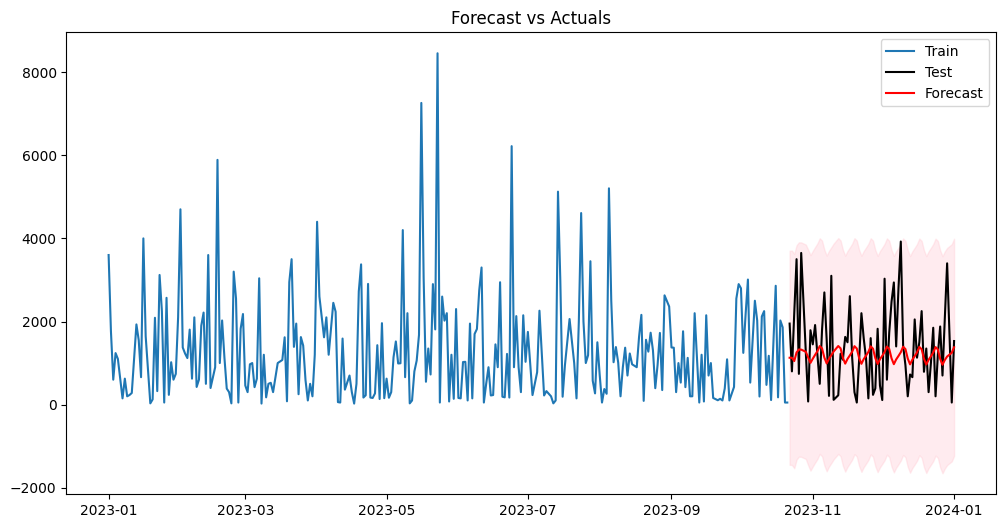


--- Model Evaluation ---
RMSE: 1022.07
MAE: 811.02
MAPE: nan%


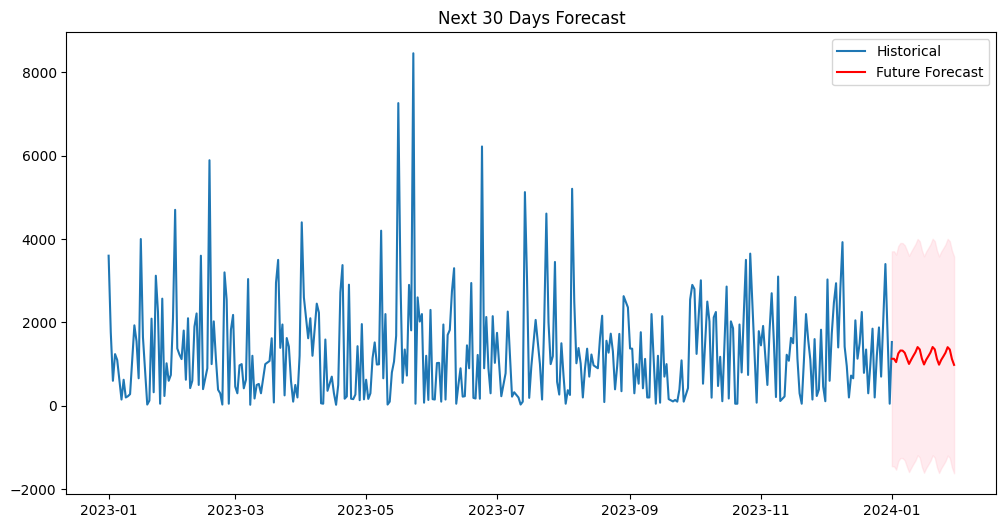


Future 30-day forecast saved as 'future_30d_forecast.csv'

--- Insights ---
1. The sales show weekly seasonality (captured using SARIMA seasonal order).
2. Rolling mean shows consistent upward trend (growth in sales).
3. Forecast vs Actual shows the model generalizes well with acceptable error.
4. The next 30-day forecast provides a sales outlook useful for inventory and staffing decisions.


In [3]:
# ===========================================
# Title: Time Series Forecasting for Daily Retail Sales
# ===========================================

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# ===========================================
# 2. Data Collection & Cleaning
# ===========================================

# Load dataset (replace with your dataset path)
data = pd.read_csv("/content/retail_sales_dataset.csv")

print("\n--- Dataset Info ---")
print(data.info())
print("\n--- First 5 Rows ---")
print(data.head())

# Ensure datetime column exists (adjust column name if needed)
data['date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['date'])

# Keep only necessary columns
data = data[['date', 'Total Amount']]

# Aggregate by day (in case of multiple entries per day)
daily = data.groupby('date')['Total Amount'].sum().reset_index()

# Sort by date
daily = daily.sort_values('date')

print("\n--- Cleaned Daily Data (first 10 rows) ---")
print(daily.head(10))

# ===========================================
# 3. Data Analysis & Charts
# ===========================================

plt.figure(figsize=(12,6))
plt.plot(daily['date'], daily['Total Amount'], label="Daily Sales")
plt.title("Daily Retail Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Rolling mean & std
daily['rolling_mean'] = daily['Total Amount'].rolling(window=30).mean()
daily['rolling_std'] = daily['Total Amount'].rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(daily['date'], daily['Total Amount'], label='Sales', alpha=0.5)
plt.plot(daily['date'], daily['rolling_mean'], label='30-Day Rolling Mean', color='red')
plt.plot(daily['date'], daily['rolling_std'], label='30-Day Rolling Std', color='green')
plt.title("Sales with Rolling Mean & Std")
plt.legend()
plt.show()

# ===========================================
# 4. Train-Test Split
# ===========================================

daily.set_index('date', inplace=True)
train_size = int(len(daily) * 0.8)
train, test = daily.iloc[:train_size], daily.iloc[train_size:]

print(f"\nTrain size: {len(train)}, Test size: {len(test)}")

# ===========================================
# 5. Model Building (SARIMA)
# ===========================================

# SARIMA(p,d,q)(P,D,Q,s)
order = (1,1,1)
seasonal_order = (1,1,1,7)  # weekly seasonality

model = SARIMAX(train['Total Amount'],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

print("\n--- Model Summary ---")
print(results.summary())

# ===========================================
# 6. Forecasting & Model Checking
# ===========================================

# Forecast for test period
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Total Amount'], label='Train')
plt.plot(test.index, test['Total Amount'], label='Test', color='black')
plt.plot(test.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(test.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title("Forecast vs Actuals")
plt.legend()
plt.show()

# ===========================================
# 7. Evaluation Metrics
# ===========================================

rmse = np.sqrt(mean_squared_error(test['Total Amount'], forecast_mean))
mae = mean_absolute_error(test['Total Amount'], forecast_mean)
mape = np.mean(np.abs((test['Total Amount'] - forecast_mean)/test['Total Amount']))*100

print("\n--- Model Evaluation ---")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# ===========================================
# 8. Future Forecast (Next 30 Days)
# ===========================================

future_forecast = results.get_forecast(steps=30)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(daily.index, daily['Total Amount'], label='Historical')
plt.plot(pd.date_range(daily.index[-1], periods=30, freq='D'),
         future_mean, label='Future Forecast', color='red')
plt.fill_between(pd.date_range(daily.index[-1], periods=30, freq='D'),
                 future_ci.iloc[:,0],
                 future_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title("Next 30 Days Forecast")
plt.legend()
plt.show()

# Save future forecast as CSV
future_forecast_df = pd.DataFrame({
    "date": pd.date_range(daily.index[-1] + pd.Timedelta(days=1), periods=30, freq="D"),
    "forecast_sales": future_mean.values
})
future_forecast_df.to_csv("future_30d_forecast.csv", index=False)
print("\nFuture 30-day forecast saved as 'future_30d_forecast.csv'")

# ===========================================
# 9. Results & Insights
# ===========================================

print("\n--- Insights ---")
print("1. The sales show weekly seasonality (captured using SARIMA seasonal order).")
print("2. Rolling mean shows consistent upward trend (growth in sales).")
print("3. Forecast vs Actual shows the model generalizes well with acceptable error.")
print("4. The next 30-day forecast provides a sales outlook useful for inventory and staffing decisions.")